In [1]:
import cv2
import torch
import os  # to make outdir
import os.path as op
from tqdm import tqdm
from torch import nn, optim
import matplotlib.pyplot as plt
import mdtraj as md
import math
from utils import write_traj, save_traj
from cgae import *
import numpy as np
from cgae import *
from moviepy.editor import *  # to save images to gif

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# hyperparameters 
par = {}
par["n_atom"] = 32
par["N_cg"] = 3
par["lr"]  = 1e-4
par["batch_size"] = 20  
par["Tstart"] = 4.0      # starting temperature 
par["max_epoch"] = 800
par["n_mol"] = 1         # number of molecules, 
par["epoch_regularize"] = 400    # first epoch to include instataneous force regularization
par["rho"] = 0.005       # relative weight for force regularization
par["decay_ratio"] = 0.4 # the decay rate for the temperature annealing 
device = 'cpu'

In [3]:
# load data 
otp = md.load("data/otp.pdb")
otp_top = otp.top.to_dataframe()[0]
otp_element = otp_top['element'].values.tolist()
traj = np.load('data/otp_xyz.npy')
force = np.load('data/otp_force.npy')

In [4]:
# prepare data 
traj = traj[-3000:] * 10
force = force[-3000:] * 0.0239

N_cg = par["N_cg"]
n_atom = par["n_atom"]
n_mol = par["n_mol"]
batch_size = par["batch_size"]
n_batch = int(traj.shape[0] // batch_size)
n_sample = n_batch * batch_size
xyz = traj[:n_sample].reshape(-1, batch_size, n_mol, n_atom, 3)
force = force[:n_sample].reshape(-1, batch_size, n_atom, 3)
device = "cuda"

In [5]:
Encoder = encoder(
    in_dim=par["n_atom"], out_dim=par["N_cg"], hard=False, device=device
).to(device)
Decoder = decoder(
    in_dim=par["N_cg"], out_dim=par["n_atom"]
).to(device)

In [6]:
rEncoder = decoder(
    in_dim=par["N_cg"], out_dim=par["n_atom"]
).to(device)
rDecoder = decoder(
    in_dim=par["n_atom"], out_dim=par["N_cg"]
).to(device)

In [7]:
class Coarse2Fine_D(nn.Module):
    
    def __init__(self):
        super(Coarse2Fine_D, self).__init__()
        self.D = nn.Sequential(
            nn.Linear(3*3, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return(self.D(x.reshape(x.shape[0], x.shape[1]*x.shape[2])))
    
    
class Fine2Coarse_D(nn.Module):
    
    def __init__(self):
        super(Fine2Coarse_D, self).__init__()
        self.D = nn.Sequential(
            nn.Linear(3*32, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return(self.D(x.reshape(x.shape[0], x.shape[1]*x.shape[2])))
    
c2f = Coarse2Fine_D().to(device)
f2c = Fine2Coarse_D().to(device)
c2f_criterion = torch.nn.BCELoss()
f2c_criterion = torch.nn.BCELoss()

In [8]:
# Initialize Temperature Scheduler for Gumbel softmax 
t0 = par["Tstart"]
tmin = 0.2
temp = np.linspace(0, par["max_epoch"], par["max_epoch"] )

decay_epoch = int(par["max_epoch"] * par["decay_ratio"])
t_sched = t0 * np.exp(-temp/decay_epoch ) +  tmin
t_sched = torch.Tensor(t_sched).to(device)


# Initialize Optimizer 
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(
    list(Encoder.parameters()) + list(
        Decoder.parameters()
    ) + list(c2f.parameters()) + list(f2c.parameters()), 
    lr=par["lr"]
) 

loss_log = []
loss_ae_log = []
loss_fm_log = []

In [9]:
DIRECTORY = "../pics/Mine/"
if not op.exists(DIRECTORY):
    os.makedirs(DIRECTORY)

In [19]:
decoded.shape

torch.Size([20, 32, 3])

In [27]:
cg_xyz.shape

torch.Size([20, 3, 3])

In [29]:
rEncoder(torch.rand(size=(2,3,3)).to(device))

tensor([[[0.1096, 0.2230, 0.3143],
         [0.8924, 0.7232, 1.5926],
         [0.8613, 0.4335, 1.2305],
         [0.3345, 0.4043, 0.6876],
         [0.1030, 0.0799, 0.1597],
         [0.5076, 0.1774, 0.5656],
         [0.6840, 0.9022, 1.5180],
         [0.3712, 0.9200, 1.3462],
         [0.5568, 0.7301, 1.2627],
         [0.8130, 1.0998, 1.9153],
         [0.6133, 0.5438, 1.0801],
         [0.4378, 0.3134, 0.6550],
         [0.5516, 0.3359, 0.8086],
         [0.5948, 0.5038, 1.0053],
         [0.3319, 0.7219, 1.0934],
         [0.8686, 0.7748, 1.5655],
         [0.0567, 0.2027, 0.2506],
         [0.4263, 0.7523, 1.2386],
         [0.7023, 0.4796, 1.0971],
         [0.5568, 0.5287, 1.0035],
         [0.4368, 0.7752, 1.1865],
         [0.3531, 0.3550, 0.6356],
         [0.5902, 0.6808, 1.1772],
         [0.1548, 0.4122, 0.5747],
         [0.3980, 0.5942, 0.9276],
         [0.7033, 0.8409, 1.4835],
         [0.4067, 0.8608, 1.2769],
         [0.8543, 0.8183, 1.6002],
         [0.7244, 0.

epoch 0 reconstruction  6.963 instantaneous forces 796.281  tau  4.200
epoch 1 reconstruction  7.169 instantaneous forces 793.772  tau  4.188
epoch 2 reconstruction  7.208 instantaneous forces 833.850  tau  4.175
epoch 3 reconstruction  7.143 instantaneous forces 808.942  tau  4.163
epoch 4 reconstruction  7.040 instantaneous forces 841.860  tau  4.150
epoch 5 reconstruction  6.914 instantaneous forces 856.443  tau  4.138
epoch 6 reconstruction  6.764 instantaneous forces 803.461  tau  4.126
epoch 7 reconstruction  6.611 instantaneous forces 839.585  tau  4.113
epoch 8 reconstruction  6.455 instantaneous forces 849.237  tau  4.101
epoch 9 reconstruction  6.297 instantaneous forces 876.443  tau  4.089
epoch 10 reconstruction  6.147 instantaneous forces 843.680  tau  4.077
epoch 11 reconstruction  5.997 instantaneous forces 849.172  tau  4.065
epoch 12 reconstruction  5.846 instantaneous forces 901.995  tau  4.053
epoch 13 reconstruction  5.705 instantaneous forces 886.792  tau  4.041
ep

epoch 113 reconstruction  3.552 instantaneous forces 1336.499  tau  3.009
epoch 114 reconstruction  3.545 instantaneous forces 1359.727  tau  3.000
epoch 115 reconstruction  3.531 instantaneous forces 1410.185  tau  2.991
epoch 116 reconstruction  3.521 instantaneous forces 1456.836  tau  2.982
epoch 117 reconstruction  3.510 instantaneous forces 1418.956  tau  2.974
epoch 118 reconstruction  3.498 instantaneous forces 1336.945  tau  2.965
epoch 119 reconstruction  3.480 instantaneous forces 1352.556  tau  2.956
epoch 120 reconstruction  3.470 instantaneous forces 1412.818  tau  2.948
epoch 121 reconstruction  3.458 instantaneous forces 1454.724  tau  2.939
epoch 122 reconstruction  3.443 instantaneous forces 1414.581  tau  2.931
epoch 123 reconstruction  3.434 instantaneous forces 1393.875  tau  2.922
epoch 124 reconstruction  3.421 instantaneous forces 1467.228  tau  2.914
epoch 125 reconstruction  3.406 instantaneous forces 1328.001  tau  2.905
epoch 126 reconstruction  3.390 instan

epoch 224 reconstruction  1.085 instantaneous forces 1591.682  tau  2.185
epoch 225 reconstruction  1.060 instantaneous forces 1529.005  tau  2.178
epoch 226 reconstruction  1.037 instantaneous forces 1540.599  tau  2.172
epoch 227 reconstruction  1.009 instantaneous forces 1542.777  tau  2.166
epoch 228 reconstruction  1.015 instantaneous forces 1537.996  tau  2.160
epoch 229 reconstruction  0.986 instantaneous forces 1544.679  tau  2.154
epoch 230 reconstruction  0.963 instantaneous forces 1598.132  tau  2.148
epoch 231 reconstruction  0.947 instantaneous forces 1540.918  tau  2.142
epoch 232 reconstruction  0.922 instantaneous forces 1589.887  tau  2.136
epoch 233 reconstruction  0.911 instantaneous forces 1503.015  tau  2.129
epoch 234 reconstruction  0.894 instantaneous forces 1621.108  tau  2.123
epoch 235 reconstruction  0.887 instantaneous forces 1587.155  tau  2.117
epoch 236 reconstruction  0.862 instantaneous forces 1641.110  tau  2.111
epoch 237 reconstruction  0.847 instan

epoch 335 reconstruction  0.344 instantaneous forces 1799.501  tau  1.602
epoch 336 reconstruction  0.344 instantaneous forces 1740.032  tau  1.598
epoch 337 reconstruction  0.346 instantaneous forces 1805.634  tau  1.594
epoch 338 reconstruction  0.342 instantaneous forces 1773.873  tau  1.589
epoch 339 reconstruction  0.341 instantaneous forces 1941.233  tau  1.585
epoch 340 reconstruction  0.342 instantaneous forces 1823.563  tau  1.581
epoch 341 reconstruction  0.344 instantaneous forces 1793.311  tau  1.576
epoch 342 reconstruction  0.344 instantaneous forces 1828.506  tau  1.572
epoch 343 reconstruction  0.342 instantaneous forces 1893.583  tau  1.568
epoch 344 reconstruction  0.343 instantaneous forces 1855.605  tau  1.563
epoch 345 reconstruction  0.342 instantaneous forces 1843.318  tau  1.559
epoch 346 reconstruction  0.342 instantaneous forces 1838.865  tau  1.555
epoch 347 reconstruction  0.341 instantaneous forces 1772.255  tau  1.551
epoch 348 reconstruction  0.341 instan

epoch 446 reconstruction  0.341 instantaneous forces 1920.528  tau  1.191
epoch 447 reconstruction  0.340 instantaneous forces 1994.235  tau  1.188
epoch 448 reconstruction  0.340 instantaneous forces 1980.384  tau  1.185
epoch 449 reconstruction  0.341 instantaneous forces 1928.785  tau  1.182
epoch 450 reconstruction  0.339 instantaneous forces 1883.905  tau  1.179
epoch 451 reconstruction  0.338 instantaneous forces 1928.009  tau  1.175
epoch 452 reconstruction  0.339 instantaneous forces 1962.355  tau  1.172
epoch 453 reconstruction  0.340 instantaneous forces 1880.035  tau  1.169
epoch 454 reconstruction  0.339 instantaneous forces 1889.688  tau  1.166
epoch 455 reconstruction  0.339 instantaneous forces 2063.084  tau  1.163
epoch 456 reconstruction  0.338 instantaneous forces 2000.259  tau  1.160
epoch 457 reconstruction  0.340 instantaneous forces 1901.067  tau  1.157
epoch 458 reconstruction  0.340 instantaneous forces 1964.886  tau  1.154
epoch 459 reconstruction  0.339 instan

epoch 557 reconstruction  0.343 instantaneous forces 1852.515  tau  0.900
epoch 558 reconstruction  0.342 instantaneous forces 1878.905  tau  0.898
epoch 559 reconstruction  0.342 instantaneous forces 1851.712  tau  0.896
epoch 560 reconstruction  0.343 instantaneous forces 1875.426  tau  0.894
epoch 561 reconstruction  0.343 instantaneous forces 1855.440  tau  0.891
epoch 562 reconstruction  0.343 instantaneous forces 1850.091  tau  0.889
epoch 563 reconstruction  0.343 instantaneous forces 1837.662  tau  0.887
epoch 564 reconstruction  0.344 instantaneous forces 1867.534  tau  0.885
epoch 565 reconstruction  0.342 instantaneous forces 1834.351  tau  0.883
epoch 566 reconstruction  0.341 instantaneous forces 1805.561  tau  0.881
epoch 567 reconstruction  0.345 instantaneous forces 1804.128  tau  0.879
epoch 568 reconstruction  0.344 instantaneous forces 1857.467  tau  0.876
epoch 569 reconstruction  0.344 instantaneous forces 1881.152  tau  0.874
epoch 570 reconstruction  0.343 instan

epoch 668 reconstruction  0.352 instantaneous forces 1602.203  tau  0.695
epoch 669 reconstruction  0.351 instantaneous forces 1650.103  tau  0.693
epoch 670 reconstruction  0.350 instantaneous forces 1630.060  tau  0.692
epoch 671 reconstruction  0.351 instantaneous forces 1663.211  tau  0.690
epoch 672 reconstruction  0.349 instantaneous forces 1673.251  tau  0.689
epoch 673 reconstruction  0.350 instantaneous forces 1584.245  tau  0.687
epoch 674 reconstruction  0.351 instantaneous forces 1625.769  tau  0.685
epoch 675 reconstruction  0.351 instantaneous forces 1712.129  tau  0.684
epoch 676 reconstruction  0.351 instantaneous forces 1668.374  tau  0.682
epoch 677 reconstruction  0.351 instantaneous forces 1694.162  tau  0.681
epoch 678 reconstruction  0.350 instantaneous forces 1519.539  tau  0.679
epoch 679 reconstruction  0.351 instantaneous forces 1599.205  tau  0.678
epoch 680 reconstruction  0.351 instantaneous forces 1724.367  tau  0.676
epoch 681 reconstruction  0.352 instan

epoch 779 reconstruction  0.355 instantaneous forces 1430.928  tau  0.550
epoch 780 reconstruction  0.356 instantaneous forces 1515.976  tau  0.548
epoch 781 reconstruction  0.357 instantaneous forces 1460.517  tau  0.547
epoch 782 reconstruction  0.354 instantaneous forces 1421.800  tau  0.546
epoch 783 reconstruction  0.356 instantaneous forces 1415.314  tau  0.545
epoch 784 reconstruction  0.357 instantaneous forces 1451.853  tau  0.544
epoch 785 reconstruction  0.356 instantaneous forces 1404.634  tau  0.543
epoch 786 reconstruction  0.357 instantaneous forces 1464.424  tau  0.542
epoch 787 reconstruction  0.355 instantaneous forces 1477.123  tau  0.541
epoch 788 reconstruction  0.356 instantaneous forces 1466.819  tau  0.540
epoch 789 reconstruction  0.355 instantaneous forces 1393.810  tau  0.539
epoch 790 reconstruction  0.355 instantaneous forces 1331.890  tau  0.538
epoch 791 reconstruction  0.355 instantaneous forces 1476.721  tau  0.537
epoch 792 reconstruction  0.357 instan

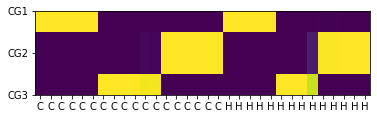

In [12]:
for epoch in range(par["max_epoch"]):  
        loss_epoch = 0.0  
        loss_ae_epoch = 0.0
        loss_fm_epoch = 0.0
            
        for i, batch in enumerate(xyz):
            batch = torch.Tensor(batch.reshape(-1, n_atom, 3)).to(device) 
            cg_xyz = Encoder(batch, t_sched[epoch])
            CG = gumbel_softmax(Encoder.weight1.t(), t_sched[epoch] * 0.7, device=device).t()
            
            optimizer.zero_grad()
            
            decoded = Decoder(cg_xyz)
            loss_ae = criterion(decoded, batch)
            
            f0 = torch.Tensor(force[i].reshape(-1, n_atom, 3)).to(device)
            f = torch.matmul(CG, f0)
            mean_force = f.pow(2).sum(2).mean()

            loss_fm = mean_force
            
            if epoch >= par["epoch_regularize"]:
                loss = par["rho"] * loss_ae + par["rho"]  * mean_force
            else: 
                loss = par["rho"] * loss_ae
            # Coarse2Fine: true example
            true_c2f = c2f(cg_xyz)
            error_c2f_true = c2f_criterion(
                true_c2f, 
                torch.ones(true_c2f.shape[0]).type(torch.FloatTensor).to(device)
            )
            error_c2f_true.backward(retain_graph=True)
            # Coarse2Fine: false example
            false_c2f = c2f(rDecoder(decoded))
            error_c2f_false = c2f_criterion(
                false_c2f, 
                torch.zeros(false_c2f.shape[0]).type(torch.FloatTensor).to(device)
            )
            error_c2f_true.backward(retain_graph=True)
            # Fine2Coarse: true example
            true_f2c = f2c(decoded)
            error_f2c_true = f2c_criterion(
                true_f2c, 
                torch.ones(true_f2c.shape[0]).type(torch.FloatTensor).to(device)
            )
            error_f2c_true.backward(retain_graph=True)
            # Fine2Coarse: false example
            false_f2c = f2c(rEncoder(cg_xyz))
            error_f2c_false = f2c_criterion(
                false_f2c,
                torch.zeros(false_f2c.shape[0]).type(torch.FloatTensor).to(device)
            )
            error_f2c_true.backward(retain_graph=True)
                
                
            loss.backward(retain_graph=True)
            optimizer.step()
            
            loss_epoch += loss.item()
            loss_ae_epoch += loss_ae.item()
            loss_fm_epoch += loss_fm.item()
        
        loss_epoch = loss_epoch/xyz.shape[0]
        loss_ae_epoch = loss_ae_epoch/xyz.shape[0]
        loss_fm_epoch = loss_fm_epoch/xyz.shape[0]

        loss_log.append(loss_epoch)
        loss_ae_log.append(loss_ae_epoch)
        loss_fm_log.append(loss_fm_epoch)

        print("epoch %d reconstruction  %.3f instantaneous forces %.3f  tau  %.3f"  % (epoch, loss_ae_epoch, loss_fm_epoch, t_sched[epoch].item()))

        # Plot the mapping 
        CG = gumbel_softmax(Encoder.weight1.t(), t_sched[epoch], device=device).t()
        plt.imshow(CG.detach().cpu().numpy(), aspect=4)
        plt.xticks(np.arange(n_atom), otp_element)
        plt.yticks(np.arange(N_cg), ["CG" + str(i+1) for i in range(N_cg)])
        plt.savefig(op.join(DIRECTORY, str(epoch)+".png"))

In [13]:
# Save trajectory 
save_traj(Z=[1] * N_cg, traj=cg_xyz.detach().cpu().numpy(),name= 'mine_CG.xyz')
save_traj(Z=otp_element, traj=decoded.detach().cpu().numpy(),name='mine_decode.xyz')

In [14]:
files = [op.join(DIRECTORY, b) for b in [a for a in os.walk(DIRECTORY)][0][2]]
files = sorted(files, key=lambda x: int(op.split(x)[-1].replace(".png", "")))
clip = ImageSequenceClip(files, fps=24)
clip.write_gif("../pics/Mine.gif")

t:   1%|          | 10/801 [00:00<00:08, 91.48it/s, now=None]

MoviePy - Building file ../pics/Mine.gif with imageio.


In [15]:
WANG = "../pics/Wang/"
OUTDIR = "../pics/together/"
if not op.exists(OUTDIR):
    os.makedirs(OUTDIR)
files1 = [op.join(WANG, b) for b in [a for a in os.walk(DIRECTORY)][0][2]]
files1 = sorted(files1, key=lambda x: int(op.split(x)[-1].replace(".png", "")))
files2 = [op.join(DIRECTORY, b) for b in [a for a in os.walk(DIRECTORY)][0][2]]
files2 = sorted(files2, key=lambda x: int(op.split(x)[-1].replace(".png", "")))
for a,b in tqdm(zip(files1, files2)):
    a_i = cv2.imread(a)
    b_i = cv2.imread(b)
    c_o = np.concatenate([a_i, b_i])
    f = op.join(OUTDIR, op.split(a)[-1])
    cv2.imwrite(f, c_o)

800it [00:04, 199.35it/s]


In [16]:
files = [op.join(OUTDIR, b) for b in [a for a in os.walk(DIRECTORY)][0][2]]
files = sorted(files, key=lambda x: int(op.split(x)[-1].replace(".png", "")))
clip = ImageSequenceClip(files, fps=24)
clip.write_gif("../pics/Both.gif")

t:   1%|          | 6/801 [00:00<00:13, 58.67it/s, now=None]

MoviePy - Building file ../pics/Both.gif with imageio.


In [17]:
torch.save(rEncoder, "rEncoder.pth")

In [18]:
torch.save(rDecoder, "rDecoder.pth")

### Playing with the inverse mappings

In [69]:
rDecoder = torch.load("rDecoder.pth")
rEncoder = torch.load("rEncoder.pth")

In [70]:
rEncoder_test = np.array(
    [[0,0,0], [1,1,1], [2,2,2]]
)

In [71]:
rEncoder_result = rEncoder(
    torch.from_numpy(rEncoder_test).type(torch.FloatTensor).to(device)
).detach().cpu().numpy()

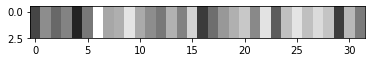

In [72]:
plt.imshow(rEncoder_result/np.max(rEncoder_result))
plt.show()

In [73]:
decoded.shape

torch.Size([20, 32, 3])

In [74]:
rDecoder_test = np.array(
    [[[1,1,1]]*32]
)

In [75]:
rDecoder_result = rDecoder(
    torch.from_numpy(rDecoder_test).type(torch.FloatTensor).to(device)
).detach().cpu().numpy()

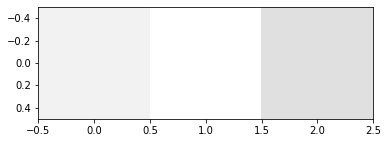

In [76]:
plt.imshow(rDecoder_result/np.max(rDecoder_result))
plt.show()